In [1]:
"""
General imports and loading of the audio file for development and explorative research.
The audio signal is normalized in the time domain to its highest value.
"""

import numpy as np
import matplotlib.pyplot as plt
import os
%run transient_shaper_lib.ipynb

SAMPLE_LENGTH = 10

def read_audio_files(directory):
  """
  Reads all audio files from a directory and returns their data with file name labels.

  Args:
      directory: The directory path (string).

  Returns:
      A list of tuples, where each tuple contains:
          - The audio data as a NumPy array.
          - The filename (without extension).
  """

  audio_data_list = []
  for filename in os.listdir(directory):
    if filename.endswith(".wav"):  # Check for .wav files
        filepath = os.path.join(directory, filename)
        sample_rate, audio_data = sp.io.wavfile.read(filepath)
        try:
          audio_data = audio_data[:, 0]
        except:
          pass
        n_bits = 32  # Assuming 32-bit audio
        audio_data = audio_data / (2**(n_bits - 1))  # Adjust range to -1 to 1 
        audio_data /= np.abs(np.max(audio_data))  # Safer normalization
        audio_data = audio_data[: sample_rate * SAMPLE_LENGTH]
        label = os.path.splitext(filename)[0]  # Extract filename without extension
        audio_data_list.append((audio_data, label, sample_rate))

  return audio_data_list

audio_data_with_labels = read_audio_files(os.getcwd())

print("Audio data and labels:")
for audio_data, label, sample_rate in audio_data_with_labels:
  print(f"- Label: {label}, Audio data shape: {audio_data.shape}, Sample rate: {sample_rate}")

FRAME_LEN = 1   # in s


Audio data and labels:
- Label: db Candy monster, lose weight snippet, Audio data shape: (259126,), Sample rate: 96000


C:\Users\J\AppData\Local\Temp\ipykernel_17788\1147491842.py:30: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sample_rate, audio_data = sp.io.wavfile.read(filepath)


db Candy monster, lose weight snippet
Tempo:  141.9558359621451
TA1:  0.01828125
TA2:  0.34788194444444437
-------


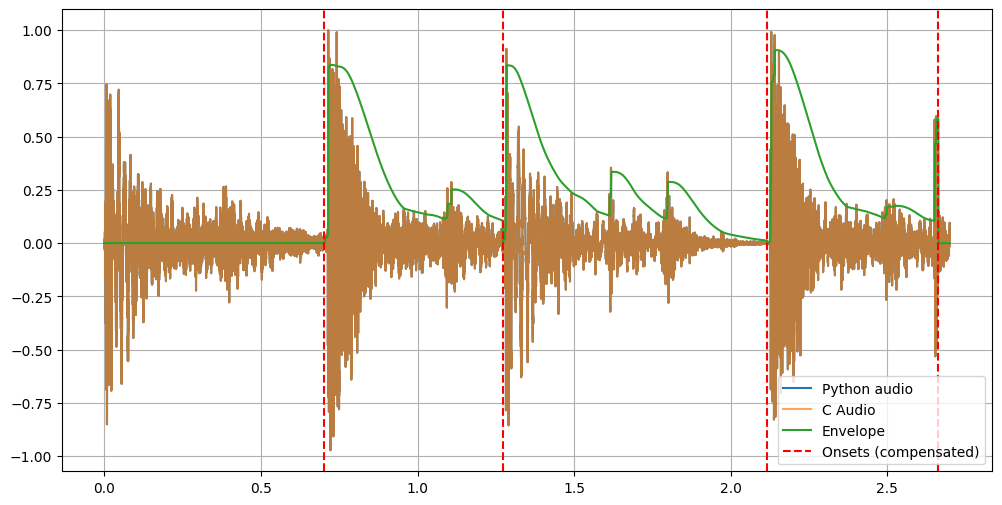

In [2]:
sampleRate = 96000
BEAT_DETECTION_BUFFER_SIZE = 64
AUDIO_BUFFER_SIZE_S = 8
AUDIO_BUFFER_SIZE = sampleRate * AUDIO_BUFFER_SIZE_S
MAX_ONSETS = 4 * AUDIO_BUFFER_SIZE_S # 4 BPS IS 240 BPM


from ctypes import *
lib = CDLL("../src/af/AFInC.dll")  # Adjust path accordingly

lib.resetBuffer.argtypes = []
lib.resetBuffer.restype = None

lib.BeatDetectionInit.argtypes = []
lib.BeatDetectionInit.restype = None

lib.AFInCAppend.argtypes = [c_double]
lib.AFInCAppend.restype = None

lib.AFInCProcess.argtypes = []
lib.AFInCProcess.restype = None

lib.afGetT1A.argtypes = []
lib.afGetT1A.restype = c_double

lib.afGetT2A.argtypes = []
lib.afGetT2A.restype = c_double

lib.afGetTempo.argtypes = []
lib.afGetTempo.restype = c_double


# ----------------------------------------
# debug helpers
# ----------------------------------------
lib.__getAudioBuffer.argtypes = []
lib.__getAudioBuffer.restype = c_double

lib.__getEnvBuffer.argtypes = []
lib.__getEnvBuffer.restype = c_double

lib.__getOnsetBuffer.argtypes = []
lib.__getOnsetBuffer.restype = c_double

lib.__resetIndexDebug.argtypes = []
lib.__resetIndexDebug.restype = None


target_device_audio_buffer = []
envelope = []
onsets = []
lib.BeatDetectionInit()

for song in audio_data_with_labels:
    lib.resetBuffer()
    print(song[1])
    for sample in song[0]:
        lib.AFInCAppend(sample)

    lib.AFInCProcess()
    
    print("Tempo: ", lib.afGetTempo())
    print("TA1: ", lib.afGetT1A())
    print("TA2: ", lib.afGetT2A())
    print("-------")
    
    lib.__resetIndexDebug()
    for sample in song[0]:
        target_device_audio_buffer.append(lib.__getAudioBuffer())
        envelope.append(lib.__getEnvBuffer())
    
    for onset in range(MAX_ONSETS):
        onsets.append(lib.__getOnsetBuffer())

    plt.figure(figsize=(12, 6))
    plt.plot([i/sampleRate for i in range(len(song[0]))], song[0], label="Python audio")
    plt.plot([i/sampleRate for i in range(len(target_device_audio_buffer))], target_device_audio_buffer, alpha=0.7, label="C Audio")
    plt.plot([i/sampleRate for i in range(len(envelope))], envelope, label="Envelope")
    for i, onset in enumerate(onsets):
        if int(onset) != 0:
            if i == 0:
                plt.axvline(x=int(onset)/sampleRate, color='r', linestyle='--', label="Onsets (compensated)")
            else:
                plt.axvline(x=int(onset)/sampleRate, color='r', linestyle='--')
        
    plt.legend()
    plt.grid()
    plt.show()
